# load libraries

In [1]:
import sys
sys.path.append('./hs_implementation')
sys.path.append('/Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess')
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pdb
import utility as utl
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!

import functools
from typing import Any, Dict, Text,Tuple,Optional


import enum
import pickle
from absl import logging
import numpy as np


import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

import sonnet as snt

from graph_nets import graphs
from graph_nets import modules as gn_modules
from graph_nets import utils_tf
from gnn_graphnet_model import *
from graph_nets import utils_np

from sklearn.preprocessing import StandardScaler
from scipy import stats


# utility funcs

In [68]:

def load_test_data(test_data_file_path,test_data_file_path2nd):
    # read the csv file and return the text line list.
    test_data_row_list = pd.read_csv(test_data_file_path,sep=',')
    test_data_row_list2nd = pd.read_csv(test_data_file_path2nd,sep=',')
    print('open and load data from test_data.csv complete.')
    return test_data_row_list, test_data_row_list2nd

def train_test_split(x,y):
    xlo, xhi = x.min(), x.max()
    ylo, yhi = y.min(), y.max()
    x_copy = np.array(x.copy() - xlo)
    y_copy = np.array(y.copy() - ylo)
    
    return x_copy < 0.7 * (xhi-xlo)

    
def base_graph( 
               test_data_file_path, 
               test_data_file_path2nd,
               logtrans=False
              ):
    """
    This here loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target 	     here the array containing the nodal target data
        weight	     if needed, a weight parameter given for the (training) nodes
    """
    
    test_data, test_data2nd = load_test_data(test_data_file_path, 
                                             test_data_file_path2nd
                                            )
    positions = np.c_[test_data[['x']]].tolist() #,'perimeter','boundarySize','numNeighbors'
    edges = list(map(lambda x:[x],np.array(test_data2nd['misOrientationAngle(deg)'])))
    receivers = list(test_data2nd['grain_j_index'].astype(int))
    senders = list(test_data2nd['grain_i_index'].astype(int)) 
    target = list(map(lambda x:[float(x)],range(np.array(test_data['x']).shape[0]))) #list(map(lambda x:[x],np.array(test_data['h(Gpa)'])))
    
    train_mask = train_test_split(test_data['x'],test_data['x']) #--- change!!!!
    val_mask = test_mask = ~train_mask
    weight = list(np.ones(test_data.shape[0]))
    
    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },\
            train_mask, val_mask, test_mask, target, weight 

#    return {"globals": [0.0],  "nodes": nodes_data[:,1:], "edges": edges_data[:,2:],  
#            "receivers": edges_data[:,1].astype(int), "senders": edges_data[:,0].astype(int)  }, 
#            train_mask, val_mask, test_mask, target, weight 



def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op


def create_corr_ops(target_op, output_op, mask):
    corr_op = tfp.stats.correlation(tf.boolean_mask(target_op, mask), tf.boolean_mask(output_op.nodes, mask))
    return corr_op




# Creating graphs

In [69]:
#--- set parameters
SEED =4441666
np.random.seed(SEED)
tf.set_random_seed(SEED)
#
pure_lab='' 
data_split = None
data_split_lab=''
#
num_processing_steps_tr = 1#3
#--- Data / training parameters.
num_training_iterations = 1#000#0 #20000
learning_rate = 7.5e-6

#--- path for csv data files
dirr='/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation'
test_data_file_path='%s/avalancheAnalysis/attributesAndHardness.csv'%dirr
test_data_file_path2nd='%s/avalancheAnalysis/pairwise_attributes.csv'%dirr


#--- graph structure  
static_graph_tr, train_mask_np, val_mask_np, test_mask_np,\
target_nodes_np, weight_np = base_graph(test_data_file_path, 
                                        test_data_file_path2nd,
                                        logtrans=data_split)
print("NUM PROCESSING STEPS ", num_processing_steps_tr)
print("LEARNING RATE ", learning_rate)
print(static_graph_tr.keys())
for k in static_graph_tr.keys():
    try:
        print(k, static_graph_tr[k].shape)
    except AttributeError:
        print(k)

input_graph = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])
#print(input_graph)



open and load data from test_data.csv complete.
NUM PROCESSING STEPS  1
LEARNING RATE  7.5e-06
dict_keys(['globals', 'nodes', 'edges', 'receivers', 'senders'])
globals
nodes
edges
receivers
senders


## Visualize 
### euclidean space

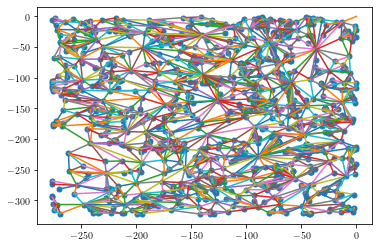

In [29]:
plt.plot(np.c_[static_graph_tr['nodes']][train_mask_np][:,0],
         np.c_[static_graph_tr['nodes']][train_mask_np][:,1],
         '.',
        markersize=10
        )
for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
    x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
    y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
    plt.plot(x,y,'-')

In [70]:

train_mask = tf.constant(train_mask_np, dtype=tf.bool)
test_mask  = tf.constant(test_mask_np , dtype=tf.bool)
val_mask   = tf.constant(val_mask_np  , dtype=tf.bool)

target_nodes = tf.constant(target_nodes_np)
weight = tf.constant(weight_np)
weight = None ##NOTE comment out if weights wanted 


# Create the model.
model = EncodeProcessDecode(node_output_size=1)
#print(model.summary())

#--- training base graph
output_ops, latent_ops = model(input_graph, num_processing_steps_tr) #[-1]
# Training loss.
loss_op_tr = []
loss_op_va = []
loss_op_ts = []
corr_op_tr = []
corr_op_va = []
corr_op_ts = []

for op in output_ops:
    loss_op_tr.append( create_loss_ops(target_nodes, op, train_mask,weight))
    loss_op_va.append( create_loss_ops(target_nodes, op,   val_mask,weight))
    loss_op_ts.append( create_loss_ops(target_nodes, op,  test_mask,weight))
    corr_op_tr.append( create_corr_ops(target_nodes, op, train_mask))
    corr_op_va.append( create_corr_ops(target_nodes, op,   val_mask))
    corr_op_ts.append( create_corr_ops(target_nodes, op,  test_mask))

# Training loss across processing steps.
loss_op_tr_sum = sum(loss_op_tr) / num_processing_steps_tr


# Optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr_sum)


training_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
correlat_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
counter = 0


# This cell resets the Tensorflow session, but keeps the same computational
# graph.
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print(snt.format_variables(model.variables))

best_corr = np.zeros((num_processing_steps_tr,3))
best_val_loss = np.inf
best_corr_loss = 0.0
best_val_loss_all = np.inf*np.ones(num_processing_steps_tr)
best_corr_loss_all = np.zeros(num_processing_steps_tr)
last_improved = 0
early_stopping_crit = 500


measure_val_by_loss= True
print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

# #--- training loop
for iteration in range(num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "outputs": output_ops,
        "latents": latent_ops,
        "corr": corr_op_tr

    })
    

    test_values = sess.run({
        "loss_val":  loss_op_va,
        "loss_test": loss_op_ts,
            "corr_val": corr_op_va,
            "corr_test": corr_op_ts
    })
    training_history[counter, 0:num_processing_steps_tr] = train_values['loss']
    training_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = test_values['loss_val']
    training_history[counter, 2*num_processing_steps_tr:] = test_values['loss_test']

    correlat_history[counter, 0:num_processing_steps_tr] = train_values['corr']
    correlat_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = test_values['corr_val']
    correlat_history[counter, 2*num_processing_steps_tr:] = test_values['corr_test']



    if (iteration+1) %10==0:
        print("# {:05d}, training {:.4f}, validation {:.4f}, test {:.4f}".format(iteration+1,training_history[counter,num_processing_steps_tr-1], training_history[counter,2*num_processing_steps_tr-1],training_history[counter,-1]  ))

        for i in range(num_processing_steps_tr):
            if measure_val_by_loss:
                cond =  (training_history[counter,num_processing_steps_tr+i] < best_val_loss_all[i])
                cond_best = (training_history[counter,num_processing_steps_tr+i] < best_val_loss)
            else:
                cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
                cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
            if cond:
                step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
#                 pdb.set_trace()
                best_corr[i,0] = stats.pearsonr( step_output[train_mask_np].flatten(),  np.array(target_nodes_np)[train_mask_np].flatten() )[0]
                best_corr[i,1] = stats.pearsonr( step_output[val_mask_np].flatten(),   np.array(target_nodes_np)[val_mask_np].flatten() )[0]
                best_corr[i,2] = stats.pearsonr( step_output[test_mask_np].flatten(),   np.array(target_nodes_np)[test_mask_np].flatten() )[0]
                #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))
                best_val_loss_all[i] = training_history[counter,num_processing_steps_tr+i]
                best_corr_loss_all[i] = correlat_history[counter,num_processing_steps_tr+i]
                if cond_best:
                    best_output = np.copy(step_output)
                    best_latent = sess.run(latent_ops[i])
                    #print(best_latent.shape)
                    best_val_loss = training_history[counter,num_processing_steps_tr+i]
                    best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
                    last_improved = counter
    counter+=1 
    if counter > last_improved + early_stopping_crit:
        print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
        break


f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

training_history = training_history[:counter]
correlat_history = correlat_history[:counter]
for i in range(num_processing_steps_tr):
    print("    {} steps:  best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
    latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
#     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)



# np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
# np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
# np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
# np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)


Variable                                                                Shape  Type     Collections                            Device
EncodeProcessDecode_14/graph_independent/node_model/node_output/b       1      float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode_14/graph_independent/node_model/node_output/w       8x1    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_28/graph_independent/edge_model/layer_norm/beta     8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_28/graph_independent/edge_model/layer_norm/gamma    8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_28/graph_independent/edge_model/mlp/linear_0/b      8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_28/graph_independent/edge_model/mlp/linear_0/w      1x8    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_28/graph_independent/edge_mode

In [43]:
with sess.as_default():
    print(output_ops[0].receivers.eval().shape)

(2581,)


In [67]:
train_values['outputs']

[GraphsTuple(nodes=array([[1.4709378],
        [1.6104755],
        [1.4681802],
        ...,
        [1.6021584],
        [1.6857686],
        [1.579567 ]], dtype=float32), edges=array([[-0.5337851 , -1.1968389 , -0.2069694 , ..., -0.9729682 ,
          1.4071815 , -0.47105807],
        [-0.15039082, -1.2538459 ,  0.05381053, ..., -1.3608365 ,
          0.9939325 , -0.36750412],
        [-0.20296195, -1.1514435 ,  0.05962645, ..., -1.3780012 ,
          0.97171706, -0.42033124],
        ...,
        [-0.13835755, -1.2756729 ,  0.0516048 , ..., -1.3571652 ,
          0.9981181 , -0.35504103],
        [-0.16277851, -1.2308053 ,  0.05576927, ..., -1.3646944 ,
          0.9893042 , -0.38019764],
        [-0.2114586 , -1.1335735 ,  0.05989414, ..., -1.3810487 ,
          0.9673932 , -0.42859977]], dtype=float32), receivers=array([ 228,  150,  135, ...,  130,  130, 1081], dtype=int32), senders=array([ 131,  132,  133, ..., 1079, 1080,  130], dtype=int32), globals=array([[ 0.3428129 ,  0.115

In [86]:
output_ops[0].edges

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_fields_defaults',
 '_make',
 '_replace',
 '_validate_none_fields',
 'count',
 'edges',
 'globals',
 'index',
 'map',
 'n_edge',
 'n_node',
 'nodes',
 'receivers',
 'replace',
 'senders']

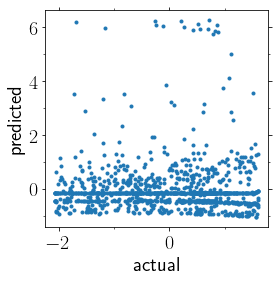

<AxesSubplot:xlabel='actual', ylabel='predicted'>

In [47]:
#ax=utl.PltErr(target_nodes_np,target_nodes_np,attrs={'fmt':'-r'},Plot=False)
filtr = [train_mask_np,test_mask_np][0]
xmin=np.min([target_nodes_np,best_output])
xmax=np.max([target_nodes_np,best_output])
utl.PltErr(utl.Zscore(np.array(target_nodes_np)), utl.Zscore(np.array(best_output)),
           attrs={'fmt':'.'},
#            xlim=(xmin,xmax),
#           ylim=(xmin,xmax),
           title = 'png/hardness.png',
           xstr='actual',
           ystr='predicted',
#           ax=ax,
          )

In [39]:
target_nodes_np

[[-39.2925],
 [-55.001],
 [-89.87787],
 [-224.7325],
 [-105.0307],
 [-54.32268],
 [-192.0816],
 [-176.5177],
 [-257.1728],
 [-98.97113],
 [-169.2267],
 [-139.9645],
 [-235.7862],
 [-260.9201],
 [-60.32267],
 [-118.6551],
 [-230.0646],
 [-78.93143],
 [-136.8735],
 [-206.9713],
 [-193.9993],
 [-213.0498],
 [-233.0342],
 [-162.9806],
 [-99.37374],
 [-36.30098],
 [-171.5333],
 [-250.8678],
 [-68.51918],
 [-113.5223],
 [-231.3513],
 [-263.6353],
 [-204.7641],
 [-179.0828],
 [-83.20202],
 [-115.2095],
 [-101.1772],
 [-255.0567],
 [-165.0898],
 [-248.9499],
 [-94.13832],
 [-139.5731],
 [-183.301],
 [-146.493],
 [-41.95308],
 [-112.3326],
 [-29.43345],
 [-154.2439],
 [-188.1351],
 [-77.12417],
 [-268.0924],
 [-224.0328],
 [-58.56845],
 [-45.72578],
 [-97.9645],
 [-79.31739],
 [-194.8348],
 [-230.659],
 [-237.3535],
 [-205.2567],
 [-173.5034],
 [-126.138],
 [-45.22479],
 [-71.94881],
 [-103.0931],
 [-22.08113],
 [-12.80168],
 [-226.3432],
 [-266.1415],
 [-184.6057],
 [-254.0631],
 [-149.5953],


(array([ 75.,  55., 247., 388.,  59.,  56.,  54.,  39.,  28.,  22.,  14.,
          5.,   3.,   3.,   2.,   1.,   0.,   3.,   4.,   1.,   4.,   1.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   7.,   7.]),
 array([-1.4912971 , -1.436339  , -1.3813809 , -1.3264229 , -1.2714648 ,
        -1.2165067 , -1.1615486 , -1.1065905 , -1.0516324 , -0.99667436,
        -0.94171625, -0.8867582 , -0.8318001 , -0.776842  , -0.72188395,
        -0.66692585, -0.6119678 , -0.5570097 , -0.5020516 , -0.44709352,
        -0.39213544, -0.33717734, -0.28221926, -0.22726119, -0.1723031 ,
        -0.11734501, -0.06238693, -0.00742884,  0.04752924,  0.10248733,
         0.15744542,  0.21240349,  0.26736158], dtype=float32),
 <BarContainer object of 32 artists>)

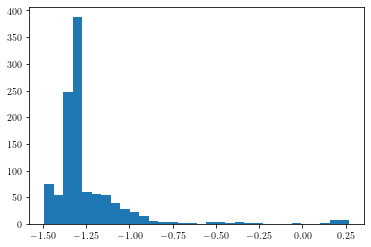

In [46]:
plt.hist(np.array(latest_output),bins=32)

In [45]:
latest_output

array([[-1.1540823],
       [-1.4624479],
       [-1.145763 ],
       ...,
       [-1.4417683],
       [-1.4380372],
       [-1.1598194]], dtype=float32)